# nuScenes devkit tutorial

Welcome to the nuScenes tutorial.

This demo assumes the database itself is available at `/data/sets/nuscenes`, and loads a mini version of the full dataset.

In [ ]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

## A Gentle Introduction to nuScenes

In this part of the tutorial, let us go through a top-down introduction of our database. This section is an elaboration of `schema.md`. Our dataset comprises of elemental building blocks that are the following:

1. `scene` - 20 second snippet of a car's journey.
2. `sample` - An annotated snapshot of a scene at a particular timestamp.
3. `sample_data` - Data collected from a particular sensor.
4. `sample_annotation` - An annotated instance of an object within our interest.
5. `instance` - Enumeration of all object instance we observed.
6. `category` - Taxonomy of object categories (e.g. vehicle, human). 
7. `attribute` - Property of an instance that can change while the category remains the same.
8. `visibility` - Fraction of pixels visible in all the images collected from 6 different cameras.. 
9. `sensor` - A specific sensor type.
10. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
11. `ego_pose` - Ego vehicle poses at a particular timestamp.
12. `log` - Log information from which the data was extracted.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

### 1. `scene`

nuScenes is a large scale database that features annotated samples across ***1000 scenes*** of approximately 20 seconds each. Let's take a look at the scenes that we have in the loaded database.

In [ ]:
nusc.list_scenes()

Let's look at a scene metadata

In [ ]:
my_scene = nusc.scene[0]
my_scene

### 2. `sample`

In scenes, we annotate our data every half a second (2 Hz).

We define `sample` as an ***annotated keyframe of a scene at a given timestamp***. A keyframe is a frame where the time-stamps of data from all the sensors should be very close to the time-stamp of the sample it points to.

Now, let us look at the first annotated sample in this scene.

In [ ]:
first_sample_token = my_scene['first_sample_token']

# The rendering command below is commented out because it tends to crash in notebooks
# nusc.render_sample(first_sample_token)

Let's examine its metadata

In [ ]:
my_sample = nusc.get('sample', first_sample_token)
my_sample

A useful method is  `list_sample()` which lists all related `sample_data` keyframes and `sample_annotation` associated with a `sample` which we will discuss in detail in the subsequent parts.

In [ ]:
nusc.list_sample(my_sample['token'])

### 3. `sample_data`

The nuScenes dataset contains data that is collected from a full sensor suite. Hence, for each snapshot of a scene, we provide references to a family of data that is collected from these sensors. 

We provide a `data` key to access these:

In [ ]:
my_sample['data']

Notice that the keys are referring to the different sensors that form our sensor suite. Let's take a look at the metadata of a `sample_data` taken from `CAM_FRONT`.

In [ ]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
cam_front_data

We can also render the `sample_data` at a particular sensor. 

In [ ]:
nusc.render_sample_data(cam_front_data['token'])

### 4. `sample_annotation`

`sample_annotation` refers to any ***bounding box defining the position of an object seen in a sample***. All location data is given with respect to the global coordinate system. Let's examine an example from our `sample` above.

In [ ]:
my_annotation_token = my_sample['anns'][18]
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
my_annotation_metadata

We can also render an annotation to have a closer look.

In [ ]:
nusc.render_annotation(my_annotation_token)

### 5. `instance`

Object instance are instances that need to be detected or tracked by an AV (e.g a particular vehicle, pedestrian). Let us examine an instance metadata

In [ ]:
my_instance = nusc.instance[599]
my_instance

We generally track an instance across different frames in a particular scene. However, we do not track them across different scenes. In this example, we have 16 annotated samples for this instance across a particular scene.

In [ ]:
instance_token = my_instance['token']
nusc.render_instance(instance_token)

An instance record takes note of its first and last annotation token. Let's render them

In [ ]:
print("First annotated sample of this instance:")
nusc.render_annotation(my_instance['first_annotation_token'])

In [ ]:
print("Last annotated sample of this instance")
nusc.render_annotation(my_instance['last_annotation_token'])

### 6. `category`

A `category` is the object assignment of an annotation.  Let's look at the category table we have in our database. The table contains the taxonomy of different object categories and also list the subcategories (delineated by a period). 

In [ ]:
nusc.list_categories()

A category record contains the name and the description of that particular category.

In [ ]:
nusc.category[9]

Refer to `instructions.md` for the definitions of the different categories.

### 7. `attribute`

An `attribute` is a property of an instance that may change throughout different parts of a scene while the category remains the same. Here we list the provided attributes and the number of annotations associated with a particular attribute.

In [ ]:
nusc.list_attributes()

Let's take a look at an example how an attribute may change over one scene

In [ ]:
my_instance = nusc.instance[27]
first_token = my_instance['first_annotation_token']
last_token = my_instance['last_annotation_token']
nbr_samples = my_instance['nbr_annotations']
current_token = first_token

i = 0
found_change = False
while current_token != last_token:
    current_ann = nusc.get('sample_annotation', current_token)
    current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])['name']
    
    if i == 0:
        pass
    elif current_attr != last_attr:
        print("Changed from `{}` to `{}` at timestamp {} out of {} annotated timestamps".format(last_attr, current_attr, i, nbr_samples))
        found_change = True

    next_token = current_ann['next']
    current_token = next_token
    last_attr = current_attr
    i += 1

### 8. `visibility`

`visibility` is defined as the fraction of pixels of a particular annotation that are visible over the 6 camera feeds, grouped into 4 bins.

In [ ]:
nusc.visibility

Let's look at an example `sample_annotation` with 80-100% visibility

In [ ]:
anntoken = 'a7d0722bce164f88adf03ada491ea0ba'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

Let's look at an example `sample_annotation` with 0-40% visibility

In [ ]:
anntoken = '9f450bf6b7454551bbbc9a4c6e74ef2e'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

### 9. `sensor`

The nuScenes dataset consists of data collected from our full sensor suite which consists of:
- 1 x LIDAR, 
- 5 x RADAR, 
- 6 x cameras, 

In [ ]:
nusc.sensor

Every `sample_data` has a record on which `sensor` the data is collected from (note the "channel" key)

In [ ]:
nusc.sample_data[10]

### 10. `calibrated_sensor`

`calibrated_sensor` consists of the definition of a particular sensor (lidar/radar/camera) as calibrated on a particular vehicle. Let us look at an example.

In [ ]:
nusc.calibrated_sensor[0]

Note that the `translation` and the `rotation` parameters are given with respect to the ego vehicle body frame. 

### 11. `ego_pose`

`ego_pose` contains information about the location (encoded in `translation`) and the orientation (encoded in `rotation`) of the ego vehicle body frame, with respect to the global coordinate system.

In [ ]:
nusc.ego_pose[0]

Note that the number of `ego_pose` records in our loaded database is the same as the number of `sample_data` records. These two records exhibit a one-to-one correspondence.

### 12. `log`

The `log` table contains log information from which the data was extracted. A `log` record corresponds to one journey of our ego vehicle along a predefined route. Let's check the number of logs and the metadata of a log.

In [ ]:
print("Number of `logs` in our loaded database: {}".format(len(nusc.log)))

In [ ]:
nusc.log[0]

Notice that it contains a variety of information such as the date and location of the log collected. It also gives out information about the map from where the data was collected. Note that one log can contain multiple non-overlapping scenes.

### 13. `map`

Map information is stored as binary semantic masks from a top-down view. Let's check the number of maps and metadata of a map.

In [ ]:
print("There are {} maps masks in the loaded dataset".format(len(nusc.map)))

In [ ]:
nusc.map[0]

## nuScenes Basics

Let's get a bit technical.

The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary. For example the first record of the category table is stored at:

In [ ]:
nusc.category[0]

The category table is simple: it holds the fields `name` and `description`. It also has a `token` field, which is a unique record identifier. Since the record is a dictionary, the token can be accessed like so:

In [ ]:
cat_token = nusc.category[0]['token']
cat_token

If you know the `token` for any record in the DB you can retrieve the record by doing

In [ ]:
nusc.get('category', cat_token)

_As you can notice, we have recovered the same record!_

OK, that was easy. Let's try something harder. Let's look at the `sample_annotation` table.

In [ ]:
nusc.sample_annotation[0]

This also has a `token` field (they all do). In addition, it has several fields of the format [a-z]*\_token, _e.g._ instance_token. These are foreign keys in database speak, meaning they point to another table. 
Using `nusc.get()` we can grab any of these in constant time. For example, let's look at the visibility record.

In [ ]:
nusc.get('visibility', nusc.sample_annotation[0]['visibility_token'])

The visibility records indicate how much of an object was visible when it was annotated.

Let's also grab the `instance_token`

In [ ]:
one_instance = nusc.get('instance', nusc.sample_annotation[0]['instance_token'])
one_instance

This points to the `instance` table. This table enumerate the object _instances_ we have encountered in each 
scene. This way we can connect all annotations of a particular object.

If you look carefully at the README tables, you will see that the sample_annotation table points to the instance table, 
but the instance table doesn't list all annotations that point to it. 

So how can we recover all sample_annotations for a particular object instance? There are two ways:

1. `Use nusc.field2token()`. Let's try it:

In [ ]:
ann_tokens = nusc.field2token('sample_annotation', 'instance_token', one_instance['token'])

This returns a list of all sample_annotation records with the `'instance_token'` == `one_instance['token']`. Let's store these in a set for now

In [ ]:
ann_tokens_field2token = set(ann_tokens)

ann_tokens_field2token

The `nusc.field2token()` method is generic and can be used in any similar situation.

2. For certain situation, we provide some reverse indices in the tables themselves. This is one such example. 

The instance record has a field `first_annotation_token` which points to the first annotation in time of this instance. 
Recovering this record is easy.

In [ ]:
ann_record = nusc.get('sample_annotation', one_instance['first_annotation_token'])
ann_record

Now we can traverse all annotations of this instance using the "next" field. Let's try it. 

In [ ]:
ann_tokens_traverse = set()
ann_tokens_traverse.add(ann_record['token'])
while not ann_record['next'] == "":
    ann_record = nusc.get('sample_annotation', ann_record['next'])
    ann_tokens_traverse.add(ann_record['token'])

Finally, let's assert that we recovered the same ann_records as we did using nusc.field2token:

In [ ]:
print(ann_tokens_traverse == ann_tokens_field2token)

## Reverse indexing and short-cuts

The nuScenes tables are normalized, meaning that each piece of information is only given once.
For example, there is one `map` record for each `log` record. Looking at the schema you will notice that the `map` table has a `log_token` field, but that the `log` table does not have a corresponding `map_token` field. But there are plenty of situations where you have a `log`, and want to find the corresponding `map`! So what to do? You can always use the `nusc.field2token()` method, but that is slow and inconvenient. We therefore add reverse mappings for some common situations including this one.

Further, there are situations where one needs to go through several tables to get a certain piece of information. 
Consider, for example, the category name (e.g. `human.pedestrian`) of a `sample_annotation`. The `sample_annotation` table doesn't hold this information since the category is an instance level constant. Instead the `sample_annotation` table points to a record in the `instance` table. This, in turn, points to a record in the `category` table, where finally the `name` fields stores the required information.

Since it is quite common to want to know the category name of an annotation, we add a `category_name` field to the `sample_annotation` table during initialization of the NuScenes class.

In this section, we list the short-cuts and reverse indices that are added to the `NuScenes` class during initialization. These are all created in the `NuScenes.__make_reverse_index__()` method.

### Reverse indices
We add two reverse indices by default.
* A `map_token` field is added to the `log` records.
* The `sample` records have shortcuts to all `sample_annotations` for that record as well as `sample_data` key-frames. Confer `nusc.list_sample()` method in the previous section for more details on this.

### Shortcuts

The sample_annotation table has a "category_name" shortcut.

_Using shortcut:_

In [ ]:
catname = nusc.sample_annotation[0]['category_name']

_Not using shortcut:_

In [ ]:
ann_rec = nusc.sample_annotation[0]
inst_rec = nusc.get('instance', ann_rec['instance_token'])
cat_rec = nusc.get('category', inst_rec['category_token'])

print(catname == cat_rec['name'])

The sample_data table has "channel" and "sensor_modality" shortcuts:

In [ ]:
# Shortcut
channel = nusc.sample_data[0]['channel']

# No shortcut
sd_rec = nusc.sample_data[0]
cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
sensor_record = nusc.get('sensor', cs_record['sensor_token'])

print(channel == sensor_record['channel'])

## Data Visualizations

We provide list and rendering methods. These are meant both as convenience methods during development, and as tutorials for building your own visualization methods. They are implemented in the NuScenesExplorer class, with shortcuts through the NuScenes class itself.

### List methods
There are three list methods available.

1. `list_categories()` lists all categories, counts and statistics of width/length/height in meters and aspect ratio.

In [ ]:
nusc.list_categories()

2. `list_attributes()` lists all attributes and counts.

In [ ]:
nusc.list_attributes()

3. `list_scenes()` lists all scenes in the loaded DB.

In [ ]:
nusc.list_scenes()

### Render

First, let's plot a lidar point cloud in an image. Lidar allows us to accurately map the surroundings in 3D.

In [ ]:
my_sample = nusc.sample[10]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

Second, let's plot the radar point cloud for the same image. Radar is less dense than lidar, but has a much larger range.

In [ ]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT')

We can also plot all annotations across all sample data for that sample. Note how for radar we also plot the velocity vectors of moving objects. Some velocity vectors are outliers, which can be filtered using the settings in RadarPointCloud.from_file()

In [1]:
my_sample = nusc.sample[20]

# The rendering command below is commented out because it tends to crash in notebooks
# nusc.render_sample(my_sample['token'])

NameError: name 'nusc' is not defined

In [2]:
from nuscenes.nuscenes import NuScenes
root = r'D:\dataset\v1.0-mini'
nusc = NuScenes(version='v1.0-mini', dataroot=root, verbose=True)
my_sample = nusc.sample[50]

Loading NuScenes tables for version v1.0-mini ...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.9 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


Or if we only want to render a particular sensor, we can specify that.

box: 14


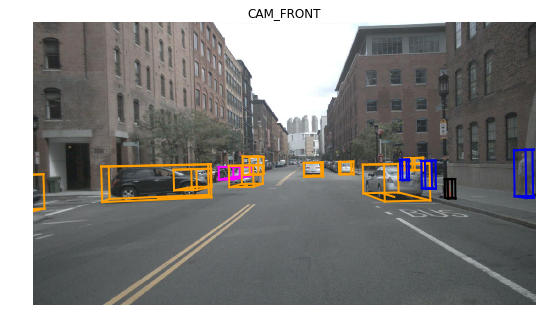

In [3]:
nusc.render_sample_data(my_sample['data']['CAM_FRONT'])

Additionally we can aggregate the point clouds from multiple sweeps to get a denser point cloud.

box: 44


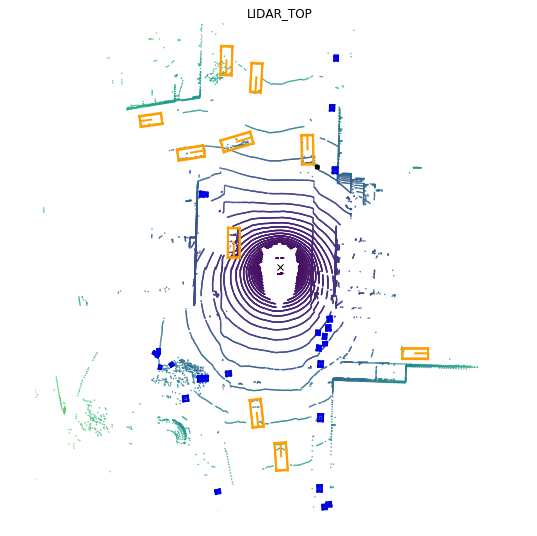

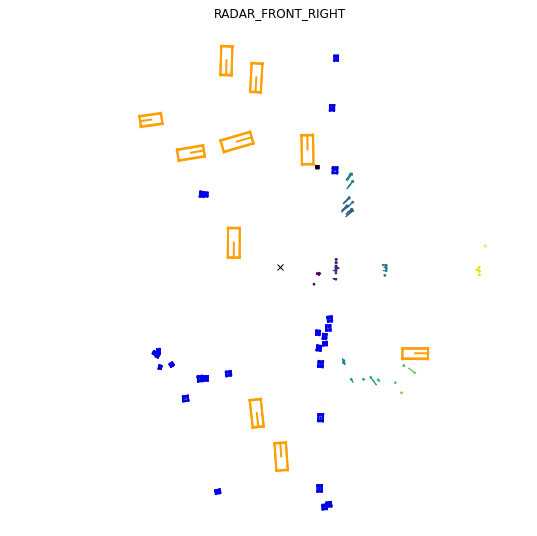

In [5]:
nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=1)
nusc.render_sample_data(my_sample['data']['RADAR_FRONT_RIGHT'], nsweeps=5)

We can even render a specific annotation.

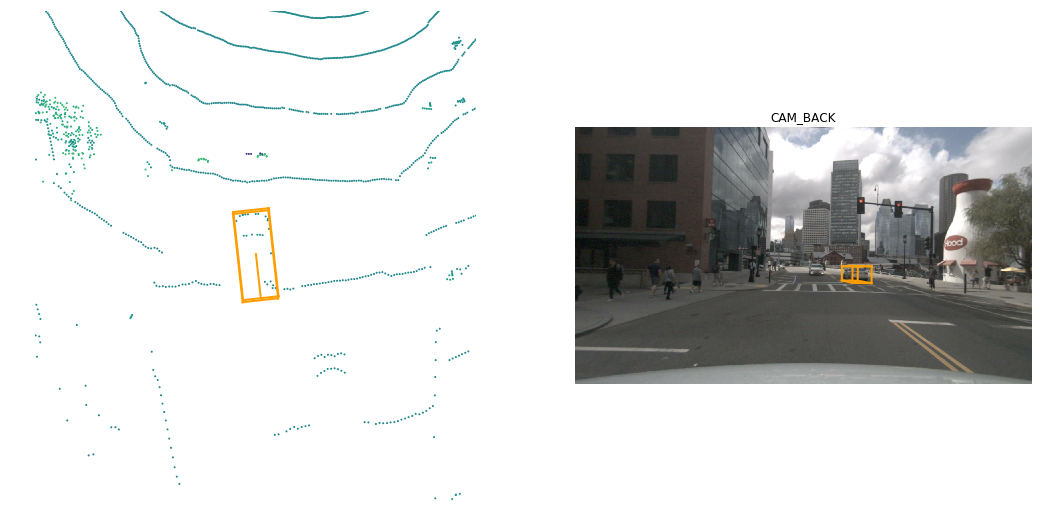

In [7]:
nusc.render_annotation(my_sample['anns'][22])

Finally, we can render a full scene as a video. There are two options here:
1. nusc.render_scene_channel() renders the video for a particular channel. (HIT ESC to exit)
2. nusc.render_scene() renders the video for all camera channels.

NOTE: These methods use OpenCV for rendering, which doesn't always play nice with IPython Notebooks. If you experience any issues please run these lines from the command line. 

Let's grab scene 0043, it is nice and dense.

In [6]:
my_scene_token = nusc.field2token('scene', 'name', 'scene-0061')[0]
nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')

There is also a method nusc.render_scene() which renders the video for all camera channels. 
This requires a high-res monitor, and is also best run outside this notebook.

In [ ]:
nusc.render_scene(my_scene_token)

Finally, let us visualize all scenes on the map for a particular location.

In [ ]:
nusc.render_egoposes_on_map(log_location='singapore-onenorth')